In [1]:
from tensorflow.keras.models import load_model

# Load trained Model
model = load_model("lane_detection_unet.keras")
print("Model input shape: ", model.input_shape)

Model input shape:  (None, 256, 256, 3)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import cv2
import os

# Compute IoU
def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    iou_metric = MeanIoU(num_classes=2)
    iou_metric.update_state(y_true, y_pred)
    return iou_metric.result().numpy()

# Compute Dice Coefficient
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

# Compute Accuracy
def compute_accuracy(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size
    return correct_pixels / total_pixels

# Compute Precision & Recall
def compute_precision_recall(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    return precision, recall


In [3]:
def load_test_images(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []

    image_files = sorted(os.listdir(image_dir))  
    mask_files = sorted(os.listdir(mask_dir))  

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size) / 255.0  

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0  
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Paths to test dataset
test_image_dir = "C:\\PGDAI\\Project\\Self Development\\Try_2\\Testing\\frames"
test_mask_dir = "C:\\PGDAI\\Project\\Self Development\\Try_2\\Testing\\lane-masks"

# Load test dataset
X_test, y_test = load_test_images(test_image_dir, test_mask_dir)


In [4]:
# Predict test images
y_pred_test = model.predict(X_test)

# Compute metrics for all test samples
iou_scores = []
dice_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for i in range(len(X_test)):
    iou = compute_iou(y_test[i], y_pred_test[i])
    dice = dice_coefficient(y_test[i], y_pred_test[i])
    accuracy = compute_accuracy(y_test[i], y_pred_test[i])
    precision, recall = compute_precision_recall(y_test[i], y_pred_test[i])

    iou_scores.append(iou)
    dice_scores.append(dice)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate mean scores
print(f"Mean IoU Score: {np.mean(iou_scores):.4f}")
print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Mean IoU Score: 0.6864
Mean Dice Coefficient: 0.6580
Mean Accuracy: 0.9541
Mean Precision: 0.7279
Mean Recall: 0.6056


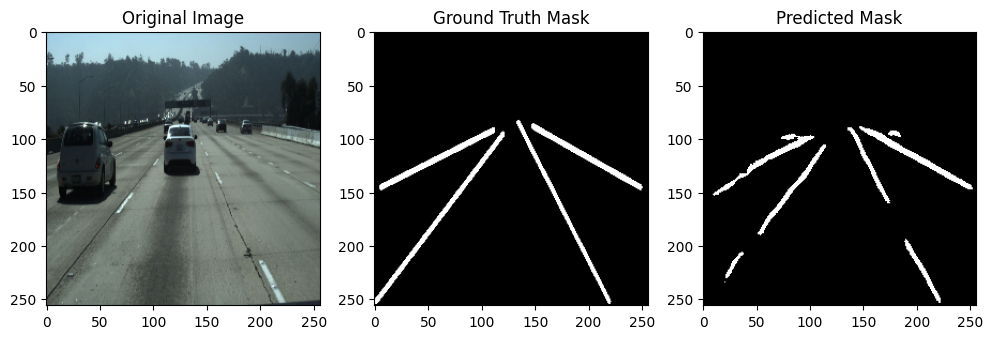

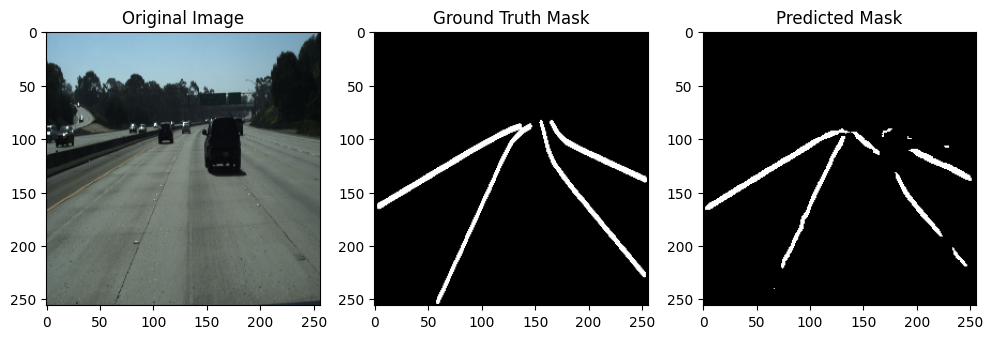

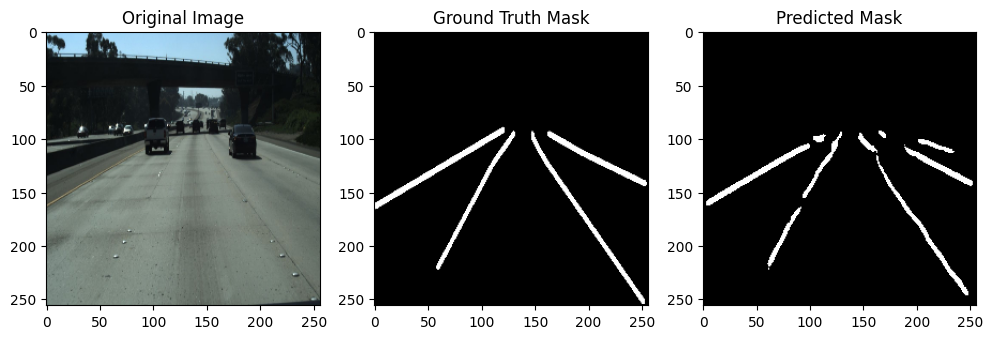

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(index):
    img = X_test[index]

    # Ensure the image is in correct format
    if img is None or img.size == 0:
        print(f"Error: Image at index {index} is empty.")
        return

    # Check if the image has correct shape
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)  # Convert back to uint8
    else:
        print(f"Error: Image shape {img.shape} is incorrect.")
        return

    true_mask = y_test[index][:, :, 0]
    pred_mask = (y_pred_test[index][:, :, 0] > 0.5).astype(np.uint8) * 255

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")

    plt.show()

# Test visualization again
visualize_predictions(10)
visualize_predictions(50)
visualize_predictions(100)
